In [1]:
import os
from collections import namedtuple

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import jax
from jax.experimental.ode import odeint, vjp_odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist
# from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

In [3]:
%reload_ext magic.write_eval

# Data

In [4]:
%%write_eval model/preprocessing.py

ix = pd.IndexSlice

def diff_pop(cumulative, pop_country):
    daily = np.hstack((np.array([0.]), np.diff(cumulative * pop_country)))
    daily += 1
    return daily

def make_dataset(subset, days_before_deaths):
    deaths_subset = subset.loc[ix[:, 'total_deaths']]

    ten_deaths_date = deaths_subset.gt(10).idxmax()
    begin_date = ten_deaths_date - pd.Timedelta(days_before_deaths, unit='days')

    total_deaths = deaths_subset.loc[begin_date:].to_numpy()
    times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()

    mobility = (subset
                .loc[ix[:, 'transit']]
                .to_frame('transit'))

    for cat in ['walking', 'driving', 
                'grocery_and_pharmacy', 'retail_and_recreation', 'workplaces', 'transit_stations']:
        mobility = mobility.join(subset.loc[ix[:, cat]].rename(cat))

    mobility = (mobility
                .reindex(deaths_subset.loc[begin_date:].index)
                .fillna(method='ffill')
                .fillna(method='bfill')
                #.fillna(mobility.iloc[-1])
                .rolling('7d').mean())
    
    mobility_data = np.asarray(mobility.to_numpy())
    return total_deaths, times, mobility_data

def make_all_datasets(full, populations_country, country_names, days_before_deaths):
    all_countries = []
    all_populations = []
    all_mobilities = []
    all_deaths = []
    all_times = []
    for country, subset in full.groupby('location'):
        if country not in country_names:
            continue
        subset = subset.reset_index('location', drop=True)
        all_countries.append(country)
#         try:
        total_deaths, times, mobility_data = make_dataset(subset, days_before_deaths)
#         except KeyError:
#             continue
        pop_country = populations_country.loc[country]
        daily_deaths = diff_pop(total_deaths / pop_country, pop_country)
        all_populations.append(pop_country)
        all_mobilities.append(mobility_data)
        all_deaths.append(daily_deaths)
        all_times.append(times)
    return all_countries, all_populations, all_mobilities, all_deaths, all_times

Overwriting model/preprocessing.py


In [5]:
SELECTED_COUNTRIES = ('Italy',)
NB_DAYS_BEFORE_TEN_DEATHS = 30

full = pd.read_csv('full.csv', index_col=['location', 'date', 'variable'], parse_dates=['date']).iloc[:, 0]
populations_country = pd.read_csv('populations_country.csv', index_col='location').iloc[:, 0]

all_countries, all_populations, all_mobilities, all_deaths, all_times = make_all_datasets(full, 
                                                                                          populations_country, 
                                                                                          SELECTED_COUNTRIES, 
                                                                                          NB_DAYS_BEFORE_TEN_DEATHS)
# to_plot = pd.DataFrame({'deaths': total_deaths}, index=times).join(mobility)
# ax = to_plot['deaths'].plot(label='deaths', figsize=(10, 5))
# mobility.plot(secondary_y=True, ax=ax, legend=False)
# plt.legend(loc='lower left')

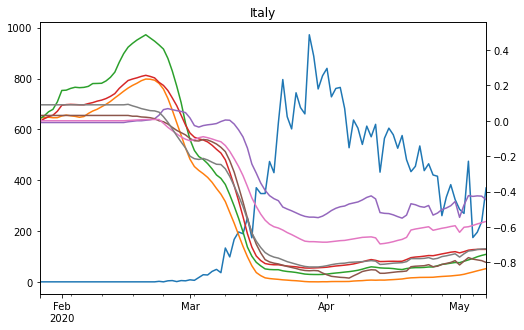

In [6]:
for i, country in enumerate(all_countries):
    pop = all_populations[i]
    mobility_data = all_mobilities[i]
    total_deaths = all_deaths[i]
    times = all_times[i]
    ax = pd.DataFrame(total_deaths).set_index(times).plot(legend=False, figsize=(8, 5))
    pd.DataFrame(mobility_data).set_index(times).plot(ax=ax, secondary_y=True, legend=False)
    plt.title(country)

In [20]:
# country = 'Italy'
# subset = full.loc[country]
# deaths_subset = subset.loc[ix[:, 'total_deaths']]
# pop_country = populations_country.loc[country]

## France data
This data is rich, because we have the number of hospitalized and critical.

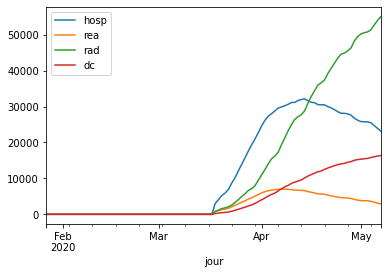

In [21]:
ix_france = np.argmax(np.array([a == 'France' for a in all_countries]))
times_fr = all_times[ix_france]

hosp = (pd.read_csv('donnees-hospitalieres-covid19-2020-05-07-19h00.csv', sep=';', parse_dates=['jour'])
        .loc[lambda f: f['sexe'] == 0]
        .groupby('jour')
        .sum()
        .drop('sexe', axis=1))

hosp_indexed = hosp.reindex(times_fr).fillna(0)
hosp_indexed.plot() ;

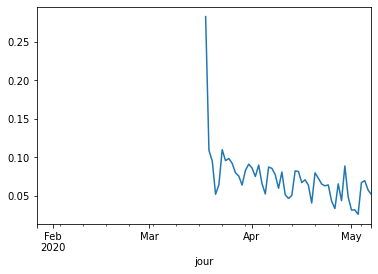

In [22]:
hosp_indexed.eval('dc.diff() / rea').plot() ;

# Model

https://www.kaggle.com/anjum48/seir-hcd-model

## Prior choice

We use France's Covid data, that includes the number of critical, deceased, hospitalized (and recovered).

In [23]:
Params = namedtuple('Params', 
                    ['r0', 'r1', 
                     't_inc', 't_inf', 't_hosp', 't_crit', 
                     'm_a', 'c_a', 'f_a']
                   )

# PRIOR_MEANS = Params(
#     r0=3.3,
#     r1=0.5, 
#     t_inc=5.1, 
#     t_inf=2.79, 
#     t_hosp=5.14, 
#     t_crit=5., 
#     m_a=0.85, 
#     c_a=0.2, 
#     f_a=0.33)

PRIOR_MEANS = Params(
    r0=3.28,
    r1=0.7, 
    t_inc=5.6, 
    t_inf=2.9, 
    t_hosp=4., 
    t_crit=14., 
    m_a=0.8, 
    c_a=0.1, 
    f_a=0.35)

BUMP_CRITICAL = abs(hosp_indexed['rea'].diff().min()) + 1
BUMP_HOSP = abs(hosp_indexed['hosp'].diff().min()) + 1

## SEIR-HCD model

In [7]:
%%write_eval ode.py
def build_my_odeint(mobility_data, rtol=1e-5, atol=1e-9, mxstep=500):
    """
    code based on jax.experimental.ode.build_ode to make it work with mobility data
    """
    def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a, *alpha):
        s = z[0]
        e = z[1]
        i = z[2]
        r = z[3]
        h = z[4]
        c = z[5]
        
        alpha_ = np.array(alpha)
        int_t = np.array([t]).astype(int)[0]
        rt_u = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]
        rt = np.dot(rt_u, alpha_)
#         rt = alpha0 * rt_u[0] + alpha1 * rt_u[1]
        
        ds = - (rt / t_inf) * i * s
        de = (rt / t_inf) * i * s - (e / t_inc)
        di = e / t_inc - i / t_inf
        dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
        dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
        dc = c_a * h / t_hosp - c / t_crit
        dd = f_a * c / t_crit

        return np.stack([ds, de, di, dr, dh, dc, dd])

    ct_odeint = jax.custom_transforms(
        lambda y0, t, *args: odeint(dz_dt, y0, t, *args, rtol=rtol, atol=atol, mxstep=mxstep))

    v = lambda y0, t, *args: vjp_odeint(dz_dt, y0, t, *args, rtol=rtol, atol=atol, mxstep=mxstep)

    jax.defvjp_all(ct_odeint, v)

    return jax.jit(ct_odeint)

Overwriting ode.py


In [26]:
# from jax.experimental.ode import build_odeint
# build_odeint??

## Bayesian model

In [8]:
%%write_eval reparameterizations.py

def reparametrize_beta(mean, sample_size):
#     v = numpyro.sample(f'sample_size_{i}', dist.Gamma(*reparametrize_gamma(10., 5)))
    alpha = mean * sample_size
    beta = (1 - mean) * sample_size
    return alpha, beta 

def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

Overwriting reparameterizations.py


In [10]:
%%write_eval model.py

def make_target_dist(psi_h, psi_c, psi, 
                     daily_hosp, daily_critical, daily_deaths, 
                     bump_hosp, bump_critical, N):
    
    target_dist = dist.GammaPoisson(
                   np.array([psi_h, psi_c, psi]),
                   rate=np.stack([psi_h / (daily_hosp + bump_hosp), 
                                  psi_c / (daily_critical + bump_critical), 
                                  psi / daily_deaths]
                                ).T
    )

    reloc = dist.transforms.AffineTransform(
        loc=np.stack([
            - bump_hosp,
            - bump_critical,
            np.zeros(N)]
        ).T,
        scale=1.)

    reloc_target_dist = dist.TransformedDistribution(target_dist, [reloc])
    return reloc_target_dist

def sample_compartment_init(pop_country, country_name=None):
#     tau = numpyro.sample('tau', dist.Exponential(0.03))
#     kappa_i0 = numpyro.sample('kappa_i0', dist.TruncatedNormal(0, 0., 0.5))
    i_init = numpyro.sample(f'i_init_{country_name}', 
                            dist.TruncatedNormal(loc=50., scale=10.)
#                             dist.Gamma(*reparametrize_gamma(50, 10.))
#                             dist.Exponential(1. / tau)
                           )
    i_init /= pop_country
    z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
    return z_init
    
def sample_parameters(nb_mobilities=1):
    kappa0 = numpyro.sample('kappa0', dist.TruncatedNormal(0, 0., 0.5))
    kappa1 = numpyro.sample('kappa1', dist.TruncatedNormal(0, 0, 0.5))
    r0 = numpyro.sample('r0', dist.TruncatedNormal(0, PRIOR_MEANS.r0, kappa0))
    r1 = numpyro.sample('r1', dist.TruncatedNormal(0, PRIOR_MEANS.r1, kappa1))

    alpha = numpyro.sample('alpha', dist.Gamma(*reparametrize_gamma(1., 0.5)), sample_shape=(nb_mobilities,))
    alpha /= np.sum(alpha)
    
    t_inc = numpyro.sample('t_inc', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inc, .86)))
    t_inf = numpyro.sample('t_inf', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inf, 3.)))
    t_hosp = numpyro.sample('t_hosp', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_hosp, 3.)))
    t_crit = numpyro.sample('t_crit', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_crit, 3.)))
    
    sample_size_m = numpyro.sample('sample_size_m', dist.Gamma(*reparametrize_gamma(7., 2)))
    sample_size_c = numpyro.sample('sample_size_c', dist.Gamma(*reparametrize_gamma(7., 2)))
    sample_size_f = numpyro.sample('sample_size_f', dist.Gamma(*reparametrize_gamma(7., 2)))
    m_a = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.m_a, sample_size_m)))
#     m_a = 0.8
    c_a = numpyro.sample('c_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.c_a, sample_size_c)))
    f_a = numpyro.sample('f_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.f_a, sample_size_f)))
    
    params = (r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)
    
    return params, alpha
    

def model(seirhcd_int, N, pop_country, y=None, compartments='d', nb_mobilities=1):
    ts = np.arange(float(N))
    params, alpha = sample_parameters(nb_mobilities=nb_mobilities)
    z_init = sample_compartment_init(pop_country)
    
    z = seirhcd_int(z_init, ts, *params, *alpha)
    
    daily_deaths = diff_pop(z[:, -1], pop_country)
    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))

    if compartments == 'd':
        numpyro.sample('deceased', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=y)

    elif compartments == 'hcd':
        daily_hosp = diff_pop(z[:, -3], pop_country)
        daily_critical = diff_pop(z[:, -2], pop_country)

        hosp = z[:, -3] * pop_country
        critical = z[:, -2] * pop_country

        hosp_m1 = np.hstack(([0.],  hosp[:-1]))
        critical_m1 = np.hstack(([0.],  critical[:-1]))

        bump_hosp = np.min(np.stack([hosp_m1, BUMP_HOSP * np.ones(N)]), axis=0)
        bump_critical = np.min(np.stack([critical_m1, BUMP_CRITICAL * np.ones(N)]), axis=0)

        psi_h = numpyro.sample('psi_h', dist.TruncatedNormal(scale=5.))
        psi_c = numpyro.sample('psi_c', dist.TruncatedNormal(scale=5.))
        
        target_dist = make_target_dist(psi_h, psi_c, psi, 
                                       daily_hosp, daily_critical, daily_deaths, 
                                       bump_hosp, bump_critical, N)
        
        numpyro.sample('y', target_dist, obs=y)

def multi_model(mobility, populations_country, observations=None):
    nb_mobilities = mobility[0].shape[1]
    params, alpha = sample_parameters(nb_mobilities=nb_mobilities)
    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))

    for country in range(len(mobility)):
        mobility_data = mobility[country]
        seirhcd_int = build_my_odeint(mobility_data)
        pop_country = populations_country[country]
        if observations is not None:
            y = np.asarray(observations[country])
        else:
            y = None
            
        ts = np.arange(float(mobility_data.shape[0]))

        z_init = sample_compartment_init(pop_country, country)
        z = seirhcd_int(z_init, ts, *params, *alpha)

        daily_deaths = diff_pop(z[:, -1], pop_country)

        numpyro.sample(f'deceased_{country}', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=y)


Overwriting model.py


## Inference

### Multi-country

In [31]:
# mobility_multi = mobility.to_numpy()[np.newaxis, :]
# observations = daily_deaths_true[np.newaxis, :]
mcmc_multi = MCMC(NUTS(multi_model, dense_mass=True), 500, 500, num_chains=NUM_CHAINS)
mcmc_multi.run(PRNGKey(0), 
               mobility=all_mobilities,
               populations_country=all_populations,
              observations=all_deaths,
              )

mcmc_multi.print_summary()

sample: 100%|██████████| 1000/1000 [09:37<00:00,  1.73it/s, 63 steps of size 8.80e-02. acc. prob=0.87] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha[0]      0.95      0.48      0.86      0.23      1.63    577.70      1.00
       alpha[1]      0.98      0.52      0.90      0.26      1.73    659.37      1.00
       alpha[2]      1.04      0.53      0.94      0.27      1.85    674.29      1.00
       alpha[3]      1.02      0.46      0.94      0.35      1.73    638.69      1.00
       alpha[4]      1.08      0.50      1.00      0.29      1.78    520.50      1.00
       alpha[5]      0.98      0.50      0.90      0.25      1.64    732.49      1.00
       alpha[6]      0.95      0.46      0.88      0.22      1.58    570.06      1.00
            c_a      0.06      0.07      0.04      0.00      0.16    228.74      1.00
            f_a      0.28      0.17      0.26      0.03      0.51    118.32      1.02
       i_init_0     45.45      9.90     45.72     30.82     61.77    411.56      1.00
         kappa0      0.42      0.32      0.35      0.

### Single country

#### D only

In [32]:
# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            500, 500, num_chains=NUM_CHAINS, progress_bar=True)

In [33]:
# # To use for D only, no H nor C
# daily_deaths_true = np.hstack((np.array([0.]), np.diff(hosp_indexed['dc'].to_numpy())))

In [34]:
daily_deaths_true = diff_pop(total_deaths / pop_country, pop_country)
mobility_data = np.asarray(mobility.to_numpy())

# integrator
seirhcd_int = build_my_odeint(mobility_data)

mcmc.run(PRNGKey(0), 
         seirhcd_int, 
         N=daily_deaths_true.shape[0], 
         pop_country = populations_country.loc[country],
         y=daily_deaths_true, 
         compartments='d',
         nb_mobilities=mobility_data.shape[1]
        )

mcmc.print_summary()

SyntaxError: invalid syntax (<ipython-input-34-cbc0371d1c40>, line 11)

In [ ]:
mobility.columns.tolist()

In [94]:
## Smoothing HCD data
daily_critical = np.hstack((np.array([0.]), np.diff(hosp_indexed['rea'].to_numpy())))
daily_hosp = np.hstack((np.array([0.]), np.diff(hosp_indexed['hosp'].to_numpy())))

raw_data = np.stack([daily_hosp, daily_critical, daily_deaths_true]).T + 1
# data = np.stack([hosp_indexed['hosp'].to_numpy(), hosp_indexed['rea'].to_numpy(), daily_deaths_true + 1]).T

data = pd.DataFrame(raw_data).rolling(10, center=True).mean().fillna(method='bfill').fillna(method='ffill').to_numpy()

df = pd.DataFrame(data)
df.columns = 'h c d'.split()

df_raw = pd.DataFrame(raw_data)
df_raw.columns = 'h c d'.split()

ax = df_raw.plot(marker='x', figsize=(10, 5))
df.plot(ax=ax)

NameError: name 'daily_deaths_true' is not defined

#### H, C and D

In [241]:
# # H, C and D inference
# mcmc.run(PRNGKey(0), seirhcd_int, 
#          N=data.shape[0], 
#          y=data, 
#          compartments='hcd')
# mcmc.print_summary()

## Result visualization

In [11]:
%%write_eval postprocess.py
def compute_mu_pi_2(y_pred):
    pop_pred = np.stack([y_pred['hosp'], y_pred['critical'], y_pred['deceased']]).T
    mu = np.mean(pop_pred, 1)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 1)
    return mu, pi

def compute_mu_pi(y_pred, observation_name='y'):
    pop_pred = y_pred[observation_name]
    mu = np.mean(pop_pred, 0)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)
    return mu, pi

def plot_compartment_results(mu, y_true, times, pi=None):
    plt.plot(times, y_true, "bx", label="true")
    plt.plot(times, mu, "b--", label="pred")
    if pi is not None:
        plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.title('Daily deaths')

def plot_daily_cumulated(mu, pi, data, times, name):
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu, data, times, pi)
    plt.title('Daily ' + name)

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(np.cumsum(mu), np.cumsum(data), times)
    plt.title('Cumulated ' + name)

# # Control for HCD params
def plot_hcd_results(mu, pi, data, times):
    for i, name in enumerate(['deaths', 'critical', 'hospitalized'], start=1):
        plot_daily_cumulated(mu[:, -i], pi[:, :, -i], data[:, -i], times, name)
        
def plot_forest(inference_data):
    az.plot_forest(inference_data, var_names=['t_inc', 't_inf', 't_hosp', 't_crit'], 
                   kind='forestplot', ridgeplot_overlap=3, combined=True, figsize=(9, 3))
    plt.grid()
    az.plot_forest(inference_data, var_names=['m_a', 'c_a', 'f_a'], figsize=(9, 2))
    plt.grid()
    az.plot_forest(inference_data, var_names=['r0', 'r1'], figsize=(9, 2))
    plt.grid()
    az.plot_forest(inference_data, var_names=['alpha'], figsize=(9, 4))
    plt.grid()


Overwriting postprocess.py


In [12]:
# predictive = Predictive(model, mcmc.get_samples())
# y_pred = predictive(PRNGKey(2), seirhcd_int, N=daily_deaths_true.shape[0], compartments='hcd')

In [37]:
predictive = Predictive(multi_model, mcmc_multi.get_samples())

In [38]:
y_pred = predictive(PRNGKey(2), 
                    mobility=all_mobilities, 
                    populations_country=populations_country)

In [39]:
mu, pi = compute_mu_pi(y_pred, 'deceased_0')

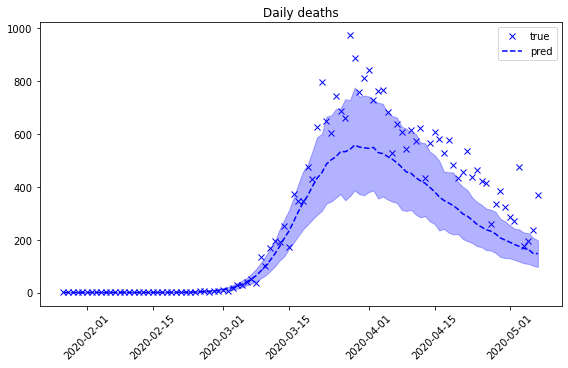

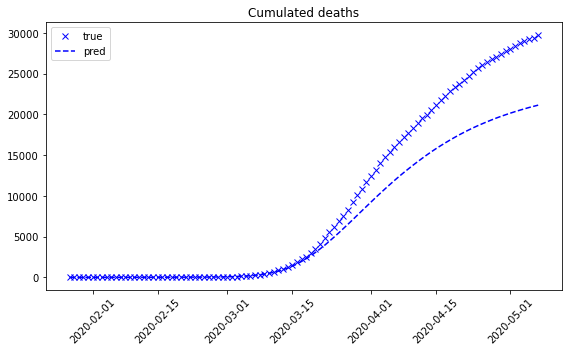

In [40]:
# plot_hcd_results(mu, pi, data, daily_deaths_true, times)
# plot_hcd_results(mu, pi, np.zeros(data.shape), daily_deaths_true, times)
# data = np.hstack([np.zeros((all_deaths[0].shape[0], 2)), all_deaths[0][:, np.newaxis]])
# plot_hcd_results(mu[:, np.newaxis], 
#                  pi[:, :, np.newaxis], 
#                  data, 
#                  all_times[0])
plot_daily_cumulated(mu, pi, all_deaths[0], times, 'deaths')
plt.tight_layout()

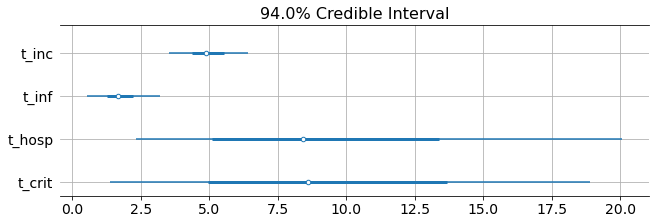

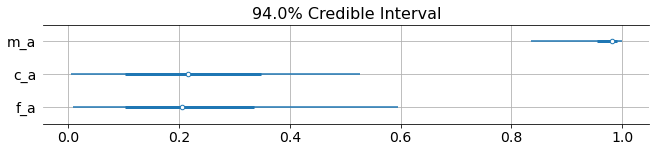

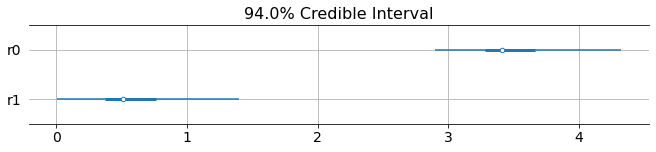

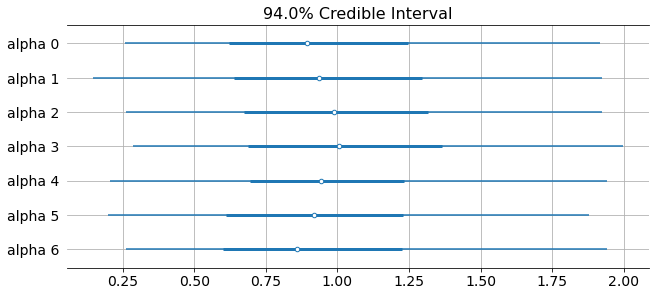

In [41]:
inference_data = az.from_numpyro(mcmc_multi)
plot_forest(inference_data)

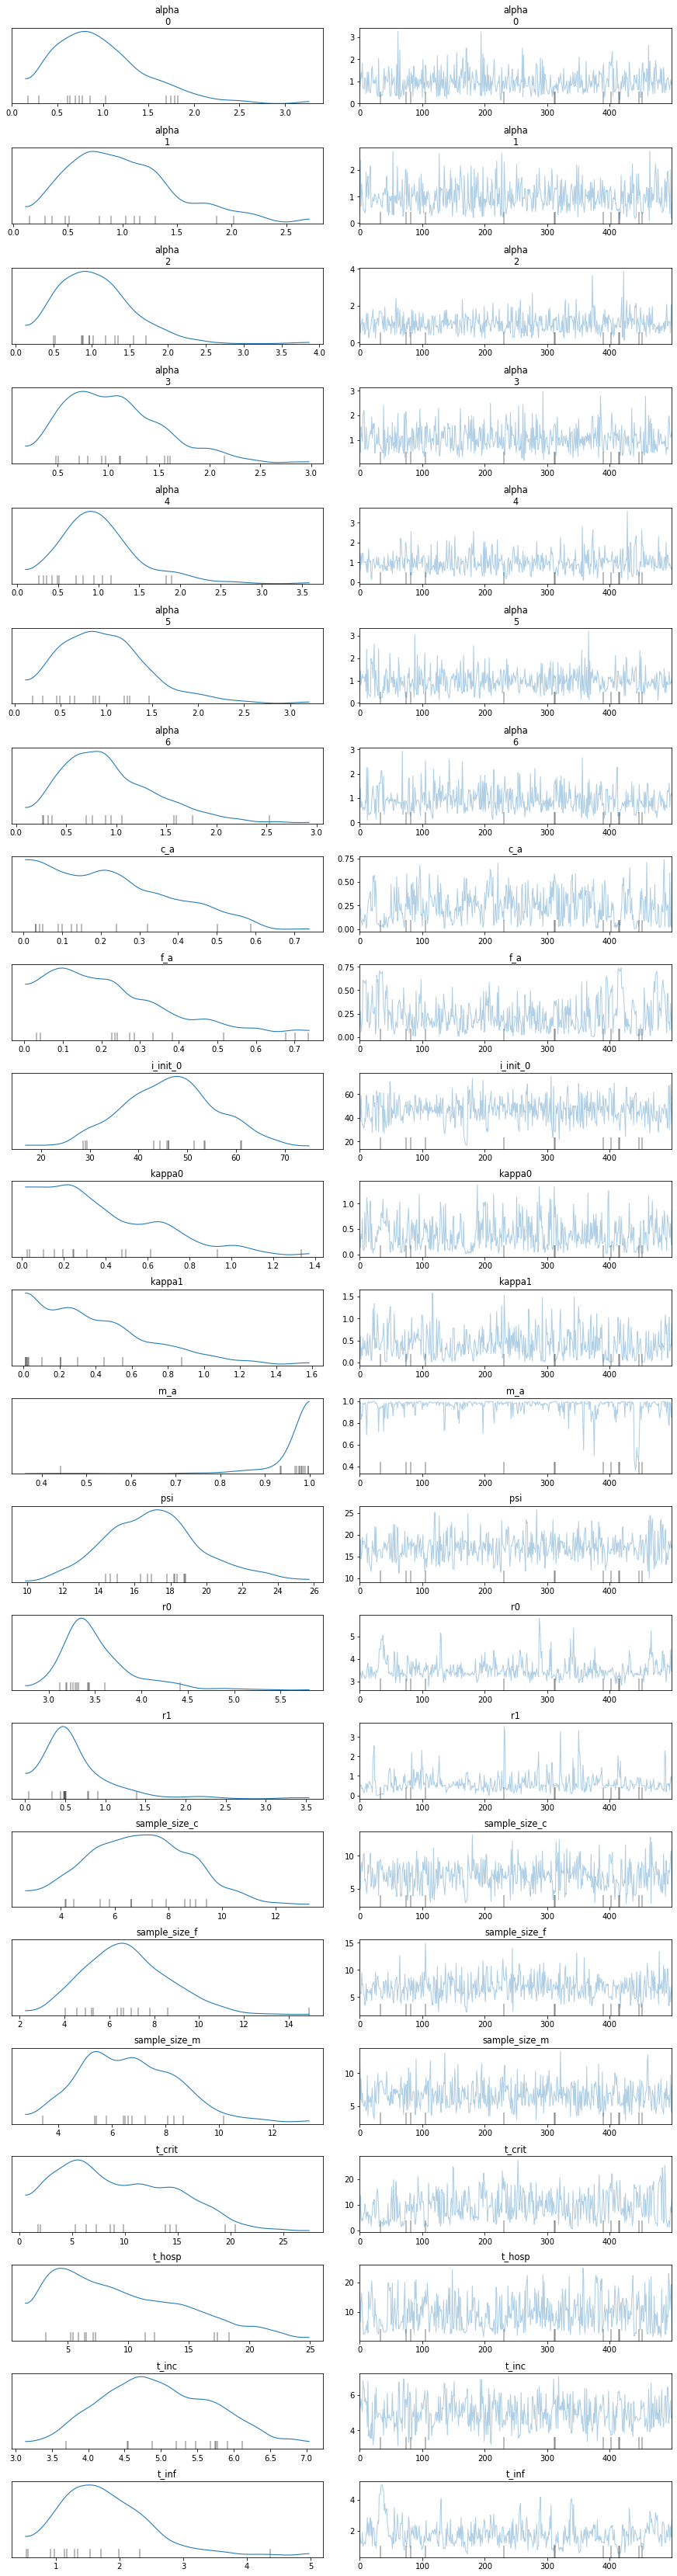

In [42]:
az.plot_trace(inference_data) ;

## Running the compartment model

In [13]:
%%write_eval compartments.py

def run_sim_samples(integrator, samples):
    ts = np.arange(float(data.shape[0]))
    res = []
    for i in range(samples['c_a'].shape[0]):
        post_params = dict()
        for param in 'r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a, alpha'.split(', '):
            post_params[param] = samples[param][i]
    #         post_params[param] = inference_data.posterior[param].values[0, -1]

        i_init = samples['i_init'][i]
        i_init /= pop_country
        z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
        args = list(post_params.values())[:-1]
        
        alpha = post_params['alpha']
        alpha /= np.sum(alpha)
        
        sim_res = integrator(z_init, ts, *args, *alpha)
        res.append(sim_res)

    res = np.stack(res)
    return res

def plot_compartment(pred_data, true_data):
    pi = np.percentile(pred_data, (10., 90.), 0)
    
    plt.plot(times, np.mean(pred_data, axis=0) * pop_country, label='pred')
    plt.plot(times, true_data, label='true')
    plt.fill_between(times, pi[0, :] * pop_country, pi[1, :] * pop_country, interpolate=True, alpha=0.3)
    plt.legend()

def plot_hcd(res, hosp_indexed):
    for i, name in enumerate(['dc', 'rea', 'hosp'], start=1):
        plt.subplots()
        plot_compartment(res[:, :, -i], hosp_indexed[name].to_numpy())
        plt.title(name)
    
def plot_seir(res):
    for i, name in enumerate(['susceptible', 'exposed', 'infected', 'recovered']):
        plt.subplots()
        plot_compartment(res[:, :, i], np.zeros(res.shape[1]))
        plt.title(name)

Overwriting compartments.py


In [269]:
samples = mcmc.get_samples()
# pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])

### True mobility

In [270]:
res = run_sim_samples(seirhcd_int, samples)

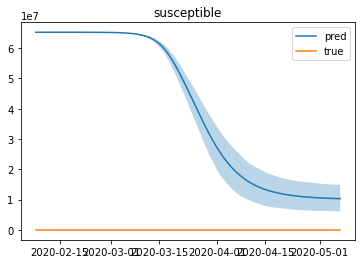

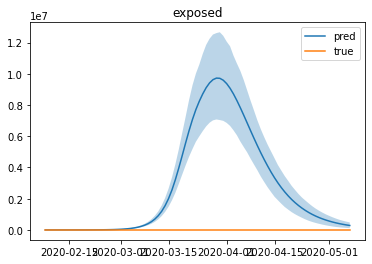

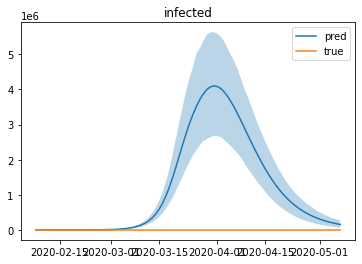

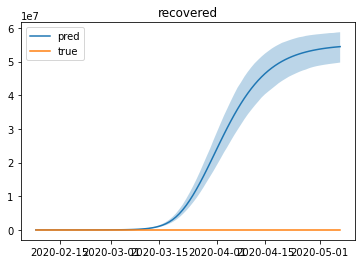

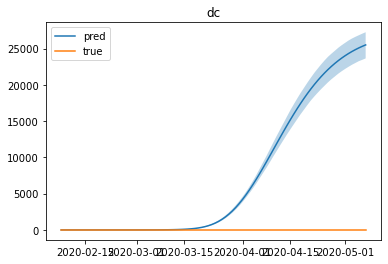

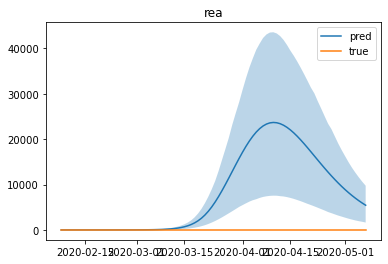

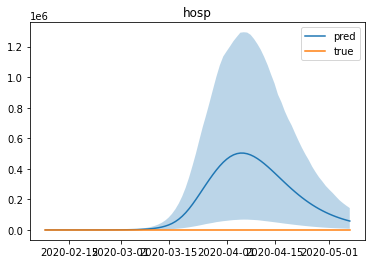

In [271]:
plot_seir(res)
plot_hcd(res, hosp_indexed.mul(0))

### Fake mobility

In [272]:
mobility_fake = np.zeros(mobility_data.shape)
seirhcd_int_zeros = build_my_odeint(mobility_fake)
res_fake = run_sim_samples(seirhcd_int_zeros, samples)

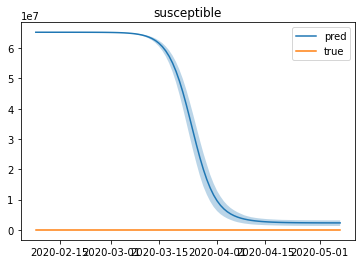

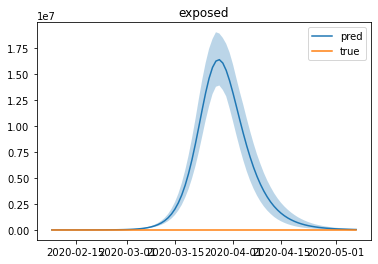

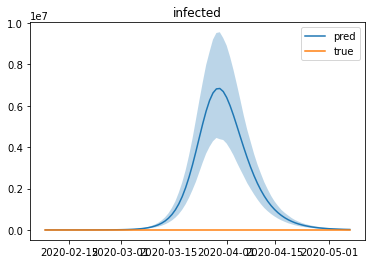

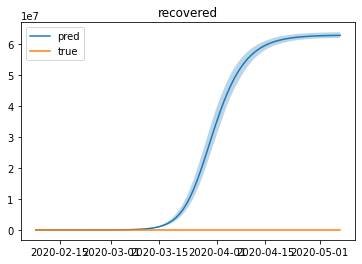

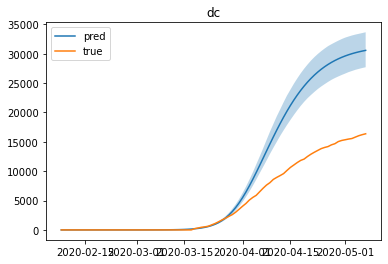

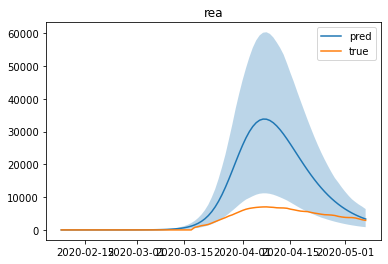

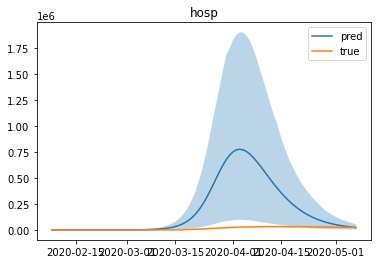

In [273]:
plot_seir(res_fake)
plot_hcd(res_fake, hosp_indexed)

## Running SEIR-HCD model with prior means

### True mobility

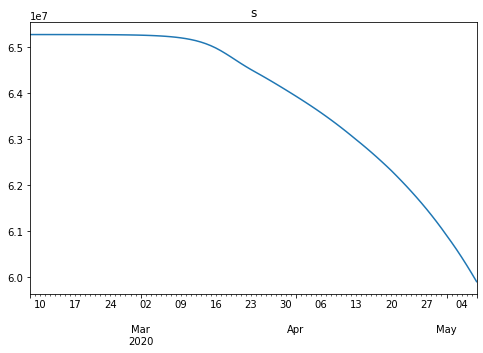

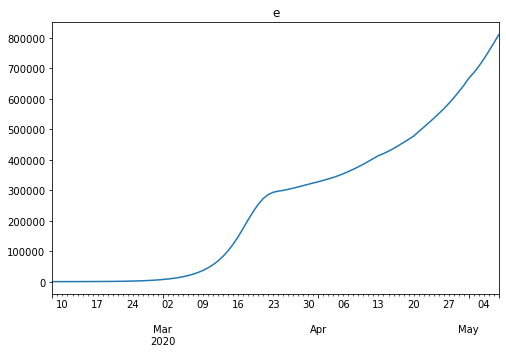

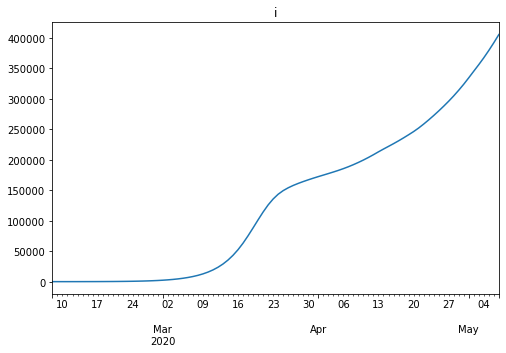

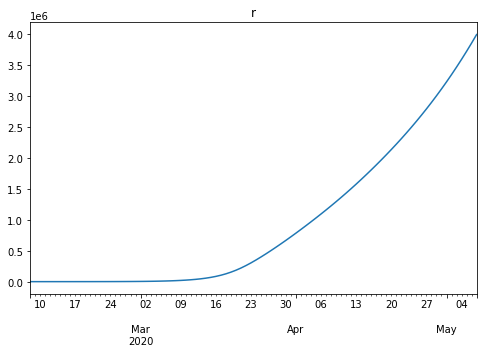

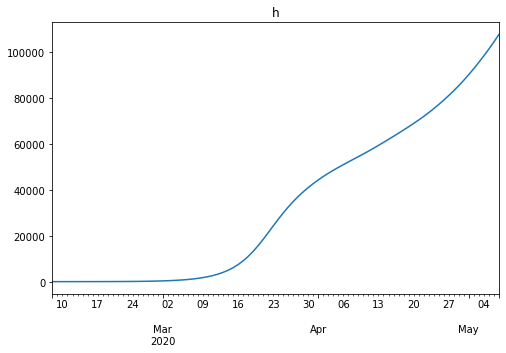

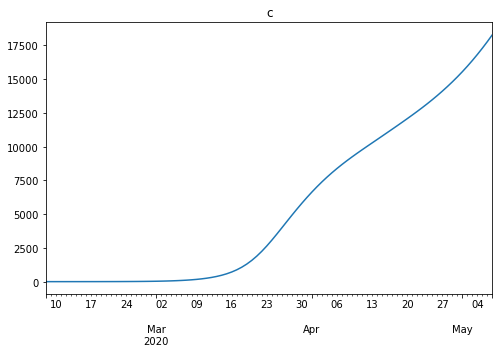

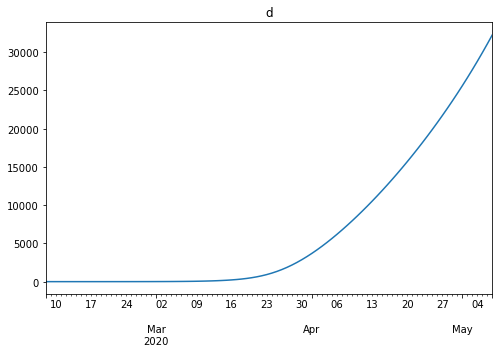

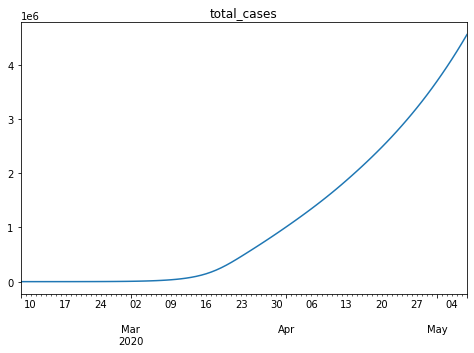

In [275]:
alpha = np.ones(mobility_data.shape[1]) / mobility_data.shape[1]
args = PRIOR_MEANS

i_init = 50
i_init /= pop_country
z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
ts = np.arange(float(data.shape[0]))

sim_res = seirhcd_int(z_init, ts, *args, *alpha)

df_res = pd.DataFrame(sim_res) * pop_country
df_res.columns = 's e i r h c d'.split()

# fig, ax = plt.subplots()
df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
for col in df_res.columns:
    plt.subplots()
    df_res[col].plot(figsize=(8, 5))
    plt.title(col)

### Fake mobility

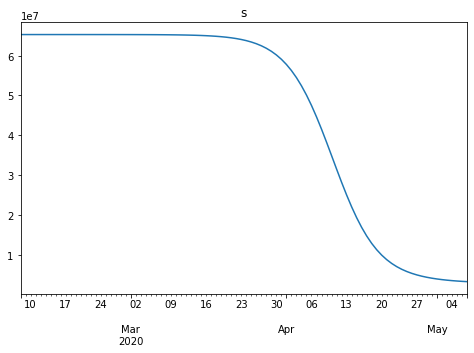

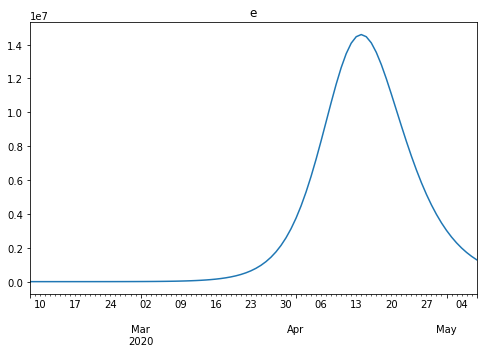

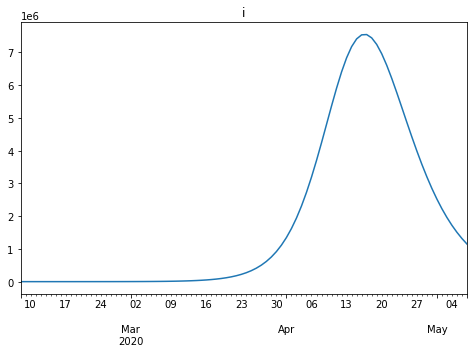

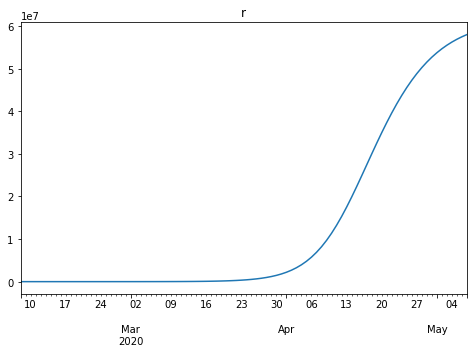

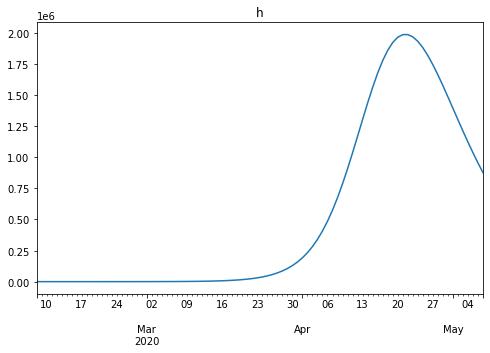

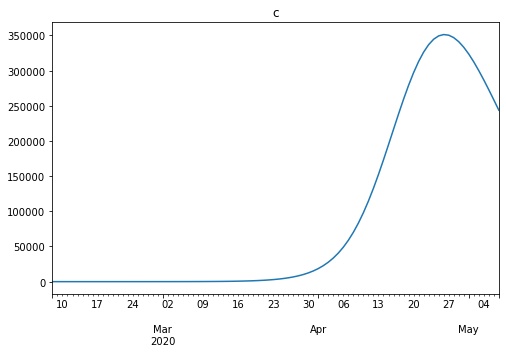

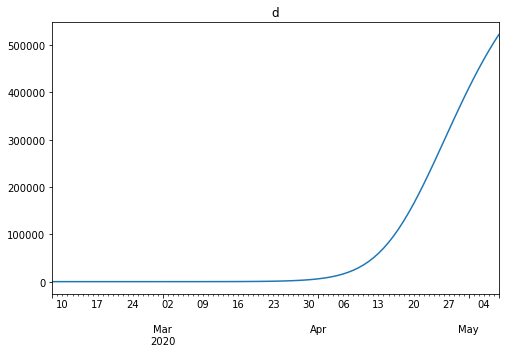

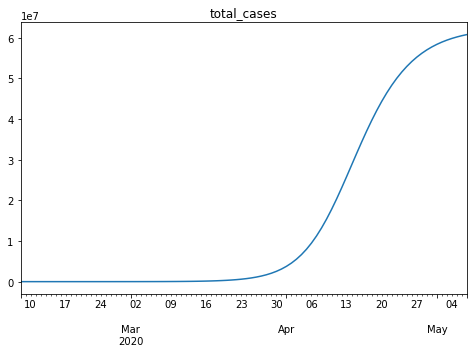

In [276]:
fake_mobility = np.zeros(mobility_data.shape)
seirhcd_int_fake = build_my_odeint(fake_mobility)
sim_res = seirhcd_int_fake(z_init, ts, *args, *alpha)

df_res = pd.DataFrame(sim_res) * pop_country
df_res.columns = 's e i r h c d'.split()

# fig, ax = plt.subplots()
df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
for col in df_res.columns:
    plt.subplots()
    df_res[col].plot(figsize=(8, 5))
    plt.title(col)

## Debug

In [116]:
params = PRIOR_MEANS
N = data.shape[0]

i_init = 50 / pop_country
z_init = np.array([1 - i_init, 0, i_init, 0, 0, 0, 0])
ts = np.arange(float(N))
z = seirhcd_int(z_init, ts, *params)

total_deaths = z[:, -1] * pop_country
daily_deaths = np.hstack((np.array([0.]), np.diff(z[:, -1] * pop_country)))
daily_deaths += 1

daily_critical = np.hstack((np.array([0]), np.diff(z[:, -2] * pop_country))) 
#     daily_critical += BUMP_CRITICAL
daily_critical += 1

daily_hosp = np.hstack((np.array([0]), np.diff(z[:, -3] * pop_country))) 
#     daily_hosp += BUMP_HOSP
daily_hosp += 1

critical = z[:, -2] * pop_country
hosp = z[:, -3] * pop_country

hosp_m1 = np.hstack(([0.],  hosp[:-1]))
critical_m1 = np.hstack(([0.],  critical[:-1]))

bump_hosp = np.min(np.stack([hosp_m1, BUMP_HOSP * np.ones(N)]), axis=0)
bump_critical = np.min(np.stack([critical_m1, BUMP_CRITICAL * np.ones(N)]), axis=0)

nb_samples = 100
samples = dict()
for i in range(nb_samples):
    psi = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i))
    psi_h = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i+1))
    psi_c = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i+2))
    target_dist = dist.GammaPoisson(
                       np.array([psi_h, psi_c, psi]),
                       rate=np.stack([psi_h / (daily_hosp + bump_hosp), 
                                      psi_c / (daily_critical + bump_critical), 
                                      psi / daily_deaths]
                                    ).T
    )

    reloc = dist.transforms.AffineTransform(
        loc=np.stack([
            - bump_hosp,
            - bump_critical,
            np.zeros(N)]
        ).T,
        scale=1.)

    reloc_target_dist = dist.TransformedDistribution(target_dist, [reloc])

    samples[i] = target_dist.sample(PRNGKey(5*i+3), (nb_samples,))

In [ ]:
for i in 1, 2, 3:
    mu = np.mean(samples[i], axis=0)
    pi = np.percentile(samples[i].astype(float), (10., 90.), axis=0)
    # df = pd.DataFrame(mu).set_index(times)
    # df.columns = 'h c d'.split()
    # # df.eval('cumul_d = d.cumsum()').plot()
    # df.plot()

    plot_hcd_results(mu, pi, data, daily_deaths_true, times)

# Misc

(0.0, 1.0)

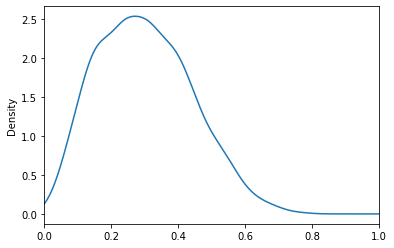

In [246]:
beta = dist.Beta(*reparametrize_beta(0.3, 10))
beta_samples = beta.sample(PRNGKey(0), (1000,))
pd.DataFrame({'samples': beta_samples}).samples.astype(float).plot.kde()
plt.xlim(0, 1)

## IHME dataset

In [2]:
df = pd.read_csv('../input/ihme-covid19/2020_05_04/Hospitalization_all_locs.csv')

In [14]:
df.set_index(['location_name', 'date']).loc["United States of America"]

,V1,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,InvVen_lower,InvVen_upper,...,icuover_lower,icuover_upper,mobility_data_type,mobility_composite,total_tests_data_type,total_tests,confirmed_infections,est_infections_mean,est_infections_lower,est_infections_upper
date,,,,,,,,,,,,,,,,,,,,,
2020-02-04,6294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,6295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,6296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,6297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,6298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-20,6492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-21,6493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-22,6494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.location_name.value_counts().sort_index().index.map(print)

Abruzzo
Alabama
Alaska
Alberta
Andalucia
Aragon
Arizona
Arkansas
Asturias
Austria
Baden-Wurttemberg
Balearic Islands
Basilicata
Basque Country
Bavaria
Belgium
Berlin
Brandenburg
Bremen
British Columbia
Bulgaria
Calabria
California
Campania
Canada
Canary Islands
Cantabria
Castile and Leon
Castilla-La Mancha
Catalonia
Ceuta
Colorado
Community of Madrid
Connecticut
Croatia
Cyprus
Czechia
Delaware
Denmark
District of Columbia
Emilia-Romagna
Estonia
Extremadura
Finland
Florida
France
Friuli-Venezia Giulia
Galicia
Georgia
Germany
Greece
Hamburg
Hawaii
Hesse
Hungary
Iceland
Idaho
Illinois
Indiana
Iowa
Ireland
Italy
Kansas
Kentucky
King and Snohomish Counties (excluding Life Care Center), WA
La Rioja
Latvia
Lazio
Life Care Center, Kirkland, WA
Liguria
Lithuania
Lombardia
Louisiana
Lower Saxony
Luxembourg
Maine
Marche
Maryland
Massachusetts
Mecklenburg-Vorpommern
Melilla
Michigan
Minnesota
Mississippi
Missouri
Molise
Montana
Murcia
Navarre
Nebraska
Netherlands
Nevada
New Hampshire
New Jersey
Ne

Index([None, None, None, None, None, None, None, None, None, None,
       ...
       None, None, None, None, None, None, None, None, None, None],
      dtype='object', length=147)